In [28]:
#import packages
import pandas as pd
from skopt import BayesSearchCV
import matplotlib.pyplot as plt

In [29]:
#read files
humidity = pd.read_csv('humidity.csv')
temperature = pd.read_csv('temperature.csv')
pressure = pd.read_csv('pressure.csv')
weather_description = pd.read_csv('weather_description.csv')
wind_direction = pd.read_csv('wind_direction.csv')
wind_speed = pd.read_csv('wind_speed.csv')

In [30]:
weather = pd.merge(humidity, temperature, on='datetime', suffixes=('_humidity', '_temperature'))
weather = pd.merge(weather, weather_description, on='datetime', suffixes= ('', '_weather_desc'))
weather = pd.merge(weather, wind_direction, on='datetime', suffixes=('', '_wind_direction'))
weather = pd.merge(weather, wind_speed, on='datetime', suffixes=('', '_wind_speed'))
weather = pd.merge(weather, pressure, on='datetime', suffixes=('', '_pressure'))
weather.dropna(inplace=True)
print(weather.shape)
weather.head()

(35101, 217)


,datetime,Vancouver_humidity,Portland_humidity,San Francisco_humidity,Seattle_humidity,Los Angeles_humidity,San Diego_humidity,Las Vegas_humidity,Phoenix_humidity,Albuquerque_humidity,...,Philadelphia_pressure,New York_pressure,Montreal_pressure,Boston_pressure,Beersheba_pressure,Tel Aviv District_pressure,Eilat_pressure,Haifa_pressure,Nahariyya_pressure,Jerusalem_pressure
27,2012-10-02 15:00:00,89.0,76.0,51.0,87.0,88.0,73.0,16.0,17.0,41.0,...,1014.0,1012.0,1002.0,1014.0,985.0,1013.0,1011.0,1013.0,1013.0,990.0
45,2012-10-03 09:00:00,81.0,77.0,68.0,71.0,53.0,78.0,19.0,25.0,39.0,...,1015.0,1015.0,1013.0,1013.0,985.0,1014.0,1013.0,1013.0,1013.0,991.0
49,2012-10-03 13:00:00,87.0,81.0,42.0,81.0,64.0,64.0,21.0,28.0,50.0,...,1016.0,1017.0,1015.0,1014.0,985.0,1013.0,1010.0,1013.0,1013.0,990.0
68,2012-10-04 08:00:00,72.0,71.0,55.0,40.0,77.0,83.0,20.0,25.0,25.0,...,1016.0,1016.0,1018.0,1017.0,987.0,1016.0,1014.0,1013.0,1013.0,992.0
72,2012-10-04 12:00:00,43.0,66.0,72.0,56.0,82.0,88.0,28.0,31.0,43.0,...,1017.0,1018.0,1019.0,1020.0,986.0,1013.0,1011.0,1013.0,1013.0,991.0


In [31]:
#look at Indianapolis specifically
indy_weather = weather.filter(regex='Indianapolis|datetime', axis=1)
indy_weather.head()

,datetime,Indianapolis_humidity,Indianapolis_temperature,Indianapolis,Indianapolis_wind_direction,Indianapolis_wind_speed,Indianapolis_pressure
27,2012-10-02 15:00:00,71.0,286.47,overcast clouds,60.0,5.0,1011.0
45,2012-10-03 09:00:00,100.0,285.15,mist,50.0,8.0,1006.0
49,2012-10-03 13:00:00,93.0,285.56,drizzle,30.0,6.0,1007.0
68,2012-10-04 08:00:00,93.0,286.86,overcast clouds,180.0,5.0,1013.0
72,2012-10-04 12:00:00,93.0,286.45,mist,180.0,4.0,1016.0


In [32]:
# Create a copy of the DataFrame to avoid modifying the original data
indy_weather = indy_weather.copy()
# Convert the 'datetime' column to a datetime object
indy_weather.loc[:, 'datetime'] = pd.to_datetime(indy_weather['datetime'], format='%Y-%m-%d %H:%M:%S')

# Extract year, month, day, hour, and day_of_week from the 'datetime' column
indy_weather.loc[:, 'year'] = indy_weather['datetime'].dt.year
indy_weather.loc[:, 'month'] = indy_weather['datetime'].dt.month
indy_weather.loc[:, 'day'] = indy_weather['datetime'].dt.day
indy_weather.head()


,datetime,Indianapolis_humidity,Indianapolis_temperature,Indianapolis,Indianapolis_wind_direction,Indianapolis_wind_speed,Indianapolis_pressure,year,month,day
27,2012-10-02 15:00:00,71.0,286.47,overcast clouds,60.0,5.0,1011.0,2012,10,2
45,2012-10-03 09:00:00,100.0,285.15,mist,50.0,8.0,1006.0,2012,10,3
49,2012-10-03 13:00:00,93.0,285.56,drizzle,30.0,6.0,1007.0,2012,10,3
68,2012-10-04 08:00:00,93.0,286.86,overcast clouds,180.0,5.0,1013.0,2012,10,4
72,2012-10-04 12:00:00,93.0,286.45,mist,180.0,4.0,1016.0,2012,10,4


In [33]:
# Perform one-hot encoding for the 'Indianapolis' column
dummy_columns = pd.get_dummies(indy_weather['Indianapolis'], prefix='weather')

# Merge the dummy columns with the original DataFrame
indy_weather_encoded = pd.concat([indy_weather, dummy_columns], axis=1)

# Drop the original 'Indianapolis' column
indy_weather_encoded.drop('Indianapolis', axis=1, inplace=True)
indy_weather_encoded.head()

,datetime,Indianapolis_humidity,Indianapolis_temperature,Indianapolis_wind_direction,Indianapolis_wind_speed,Indianapolis_pressure,year,month,day,weather_broken clouds,...,weather_scattered clouds,weather_sky is clear,weather_snow,weather_squalls,weather_thunderstorm,weather_thunderstorm with heavy rain,weather_thunderstorm with light drizzle,weather_thunderstorm with light rain,weather_thunderstorm with rain,weather_very heavy rain
27,2012-10-02 15:00:00,71.0,286.47,60.0,5.0,1011.0,2012,10,2,0,...,0,0,0,0,0,0,0,0,0,0
45,2012-10-03 09:00:00,100.0,285.15,50.0,8.0,1006.0,2012,10,3,0,...,0,0,0,0,0,0,0,0,0,0
49,2012-10-03 13:00:00,93.0,285.56,30.0,6.0,1007.0,2012,10,3,0,...,0,0,0,0,0,0,0,0,0,0
68,2012-10-04 08:00:00,93.0,286.86,180.0,5.0,1013.0,2012,10,4,0,...,0,0,0,0,0,0,0,0,0,0
72,2012-10-04 12:00:00,93.0,286.45,180.0,4.0,1016.0,2012,10,4,0,...,0,0,0,0,0,0,0,0,0,0


In [34]:
# Group by 'year', 'month', and 'day' columns and calculate the mean values for each day
daily_data = indy_weather_encoded.groupby(['year', 'month', 'day']).mean().reset_index()

# Create a new 'date' column by combining the 'year', 'month', and 'day' columns
daily_data['date'] = pd.to_datetime(daily_data[['year', 'month', 'day']])

# Set the DataFrame index to the new 'date' column
daily_data.set_index('date', inplace=True)
daily_data.head(20)


,year,month,day,Indianapolis_humidity,Indianapolis_temperature,Indianapolis_wind_direction,Indianapolis_wind_speed,Indianapolis_pressure,weather_broken clouds,weather_drizzle,...,weather_scattered clouds,weather_sky is clear,weather_snow,weather_squalls,weather_thunderstorm,weather_thunderstorm with heavy rain,weather_thunderstorm with light drizzle,weather_thunderstorm with light rain,weather_thunderstorm with rain,weather_very heavy rain
date,,,,,,,,,,,,,,,,,,,,,
2012-10-02,2012,10,2,71.000000,286.470000,60.000000,5.000000,1011.000000,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2012-10-03,2012,10,3,96.500000,285.355000,40.000000,7.000000,1006.500000,0.0,0.5,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2012-10-04,2012,10,4,93.000000,286.655000,180.000000,4.500000,1014.500000,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2012-10-06,2012,10,6,77.000000,291.280000,210.000000,3.000000,1020.000000,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2012-10-10,2012,10,10,52.000000,287.600000,204.000000,5.000000,996.000000,0.0,0.0,...,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2012-10-11,2012,10,11,49.142857,286.337143,230.428571,5.714286,1000.428571,0.0,0.0,...,0.0,0.857143,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2012-10-12,2012,10,12,40.000000,275.365000,0.000000,0.000000,1025.000000,0.0,0.0,...,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2012-10-13,2012,10,13,52.500000,283.409000,219.000000,2.000000,1021.500000,0.0,0.0,...,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2012-10-16,2012,10,16,71.000000,284.650000,290.000000,5.000000,1012.000000,0.0,0.0,...,0.0,0.500000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [35]:
# Map month values to season labels
season_mapping = {
    1: 'Winter',
    2: 'Winter',
    3: 'Spring',
    4: 'Spring',
    5: 'Spring',
    6: 'Summer',
    7: 'Summer',
    8: 'Summer',
    9: 'Autumn',
    10: 'Autumn',
    11: 'Autumn',
    12: 'Winter'
}
daily_data['season'] = daily_data['month'].map(season_mapping)
daily_data_encoded = pd.get_dummies(daily_data, columns=['season'])

daily_data_encoded.head()


,year,month,day,Indianapolis_humidity,Indianapolis_temperature,Indianapolis_wind_direction,Indianapolis_wind_speed,Indianapolis_pressure,weather_broken clouds,weather_drizzle,...,weather_thunderstorm,weather_thunderstorm with heavy rain,weather_thunderstorm with light drizzle,weather_thunderstorm with light rain,weather_thunderstorm with rain,weather_very heavy rain,season_Autumn,season_Spring,season_Summer,season_Winter
date,,,,,,,,,,,,,,,,,,,,,
2012-10-02,2012,10,2,71.0,286.470,60.0,5.0,1011.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0
2012-10-03,2012,10,3,96.5,285.355,40.0,7.0,1006.5,0.0,0.5,...,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0
2012-10-04,2012,10,4,93.0,286.655,180.0,4.5,1014.5,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0
2012-10-06,2012,10,6,77.0,291.280,210.0,3.0,1020.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0
2012-10-10,2012,10,10,52.0,287.600,204.0,5.0,996.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0


In [36]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel
# Define the preprocessing steps and the model
preprocessing_steps = StandardScaler()
model = RandomForestRegressor()  # Random Forest Regression model

# Create the feature selector
feature_selector = SelectFromModel(RandomForestRegressor())

# Create the pipeline
pipeline = Pipeline([
    ('preprocessing', preprocessing_steps),
    ('feature_selection', feature_selector),
    ('model', model)
])
# Define the input features and the target variable
features = ['year', 'month', 'day', 'Indianapolis_humidity', 'Indianapolis_temperature', 'Indianapolis_wind_direction', 'Indianapolis_pressure', 'weather_broken clouds', 'weather_drizzle', 'weather_few clouds', 'weather_fog', 'weather_haze', 'weather_heavy intensity drizzle', 'weather_heavy intensity rain', 'weather_heavy snow', 'weather_light intensity drizzle', 'weather_light intensity shower rain', 'weather_light rain', 'weather_light snow', 'weather_mist', 'weather_moderate rain', 'weather_overcast clouds', 'weather_proximity thunderstorm', 'weather_proximity thunderstorm with rain', 'weather_scattered clouds', 'weather_sky is clear', 'weather_snow', 'weather_squalls', 'weather_thunderstorm', 'weather_thunderstorm with heavy rain', 'weather_thunderstorm with light drizzle', 'weather_thunderstorm with light rain', 'weather_thunderstorm with rain', 'weather_very heavy rain', 'season_Autumn', 'season_Spring', 'season_Summer', 'season_Winter']
target_var = 'Indianapolis_wind_speed'

# Extract the input features and the target variable from the DataFrame
X = daily_data_encoded[features]
Y = daily_data_encoded[target_var]



In [37]:
from sklearn.metrics import r2_score, mean_squared_error
# Define the search space for hyperparameters
hyperparameters = {
    'model__n_estimators': (10, 250),  # Range for the number of estimators
    'model__max_depth': (1, 20),  # Range for the maximum depth
    'model__min_samples_split': (2, 10),  # Range for the minimum samples split

}

# Perform Bayesian optimization using BayesSearchCV
opt = BayesSearchCV(pipeline, hyperparameters, n_iter=16, cv=5)


In [38]:
from sklearn.model_selection import train_test_split

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=42)

# Fit the pipeline to the training data
opt.fit(X_train, y_train)
# Predict the target variable for the test data
y_pred = opt.predict(X_test)

# Evaluate the performance of the model on the test data
from sklearn.metrics import r2_score, mean_squared_error
print('R2 score:', r2_score(y_test, y_pred))
print('Mean squared error:', mean_squared_error(y_test, y_pred))



R2 score: 0.3865533204154167
Mean squared error: 1.3112686958083741


<AxesSubplot:title={'center':'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

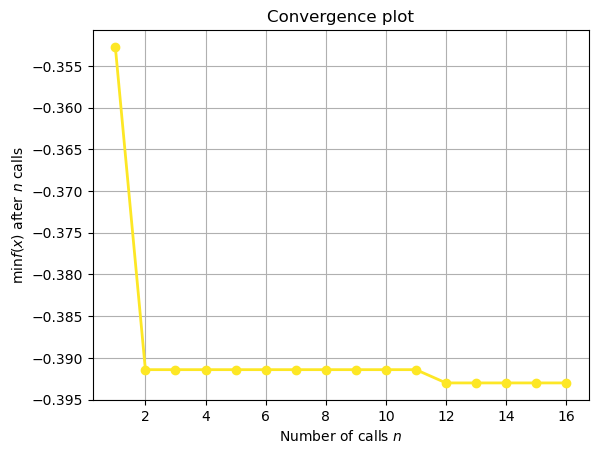

In [39]:
from skopt.plots import plot_convergence

plot_convergence(opt, opt.optimizer_results_[0])

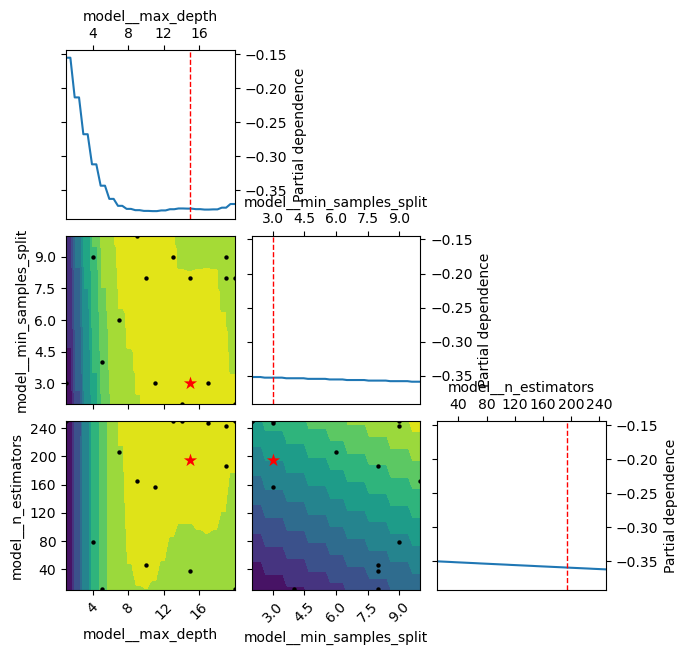

In [40]:
from skopt.plots import plot_objective

_ = plot_objective(opt.optimizer_results_[0])
plt.show()


In [44]:
# Access the best estimator from the search results
best_estimator = opt.best_estimator_

# Retrieve the feature importances from the best estimator
importance = best_estimator.named_steps['model'].feature_importances_

# Create a dictionary to map feature names to their importance scores
feature_importance = dict(zip(features, importance))

# Print the feature importances
for feature, importance_score in feature_importance.items():
    print(f"{feature}: {importance_score}")


year: 0.153682671732981
month: 0.05547529186647939
day: 0.08801343452508517
Indianapolis_humidity: 0.09726595746845809
Indianapolis_temperature: 0.1304208942680393
Indianapolis_wind_direction: 0.22586285300072587
Indianapolis_pressure: 0.034790646672146465
weather_broken clouds: 0.054623977637596376
weather_drizzle: 0.03593108438915505
weather_few clouds: 0.0470775045349309
weather_fog: 0.03064969239674232
weather_haze: 0.04620599150766017
